In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## import raw data

In [3]:
df = pd.read_excel('../df.xlsx')
df.head(3)

,Unnamed: 0,User_ID,UTC_Time,Account,Operation,Coin,Change,Remark
0,16,15578312,2021-07-15 14:37:34,Spot,Deposit,BUSD,40000.000000,NaN
1,16,15578312,2021-07-15 14:37:34,Spot,Deposit,BNB,9.000000,NaN
2,17,15578312,2021-07-15 18:06:30,Spot,Fee,BNB,-0.000944,NaN


## futures wallet

In [4]:
df_futures = df.loc[df['Account'] == 'USDT-Futures']
accum_sum = df_futures['Change'].cumsum(axis=0)
df_futures = df_futures.assign(accum_sum=accum_sum)
df_futures.head(5)

,Unnamed: 0,User_ID,UTC_Time,Account,Operation,Coin,Change,Remark,accum_sum
64,957,15578312,2021-11-07 19:54:04,USDT-Futures,transfer_in,USDT,1000.000000,NaN,1000.000000
65,958,15578312,2021-11-07 20:19:58,USDT-Futures,Fee,USDT,-1.138828,NaN,998.861172
66,959,15578312,2021-11-07 21:00:40,USDT-Futures,Fee,USDT,-0.289000,NaN,998.572172
67,960,15578312,2021-11-07 21:00:40,USDT-Futures,Fee,USDT,-0.057800,NaN,998.514372
68,961,15578312,2021-11-07 21:00:40,USDT-Futures,Fee,USDT,-0.039304,NaN,998.475068


In [17]:
funding = df_futures.loc[df_futures['Operation'] == 'transfer_in']['Change'].sum() + df_futures.loc[df_futures['Operation'] == 'transfer_out']['Change'].sum()
print(f'total funding futures account (in-out): {round(funding, 2)} USDT')
balance_futures = df_futures['accum_sum'].iloc[-1]
print(f'current balance futures account: {round(balance_futures, 2)} USDT')
print(f'gain/(loss): {round((balance_futures - funding), 2)} USDT')
fees = df_futures.loc[df_futures['Operation'] == 'Fee']['Change'].sum() + df_futures.loc[df_futures['Operation'] == 'Funding Fee']['Change'].sum()
print(f'total fees paid: {round(-fees, 2)} USDT')

total funding futures account (in-out): 832.25 USDT
current balance futures account: 2.75 USDT
gain/(loss): -829.49 USDT
total fees paid: 330.62 USDT


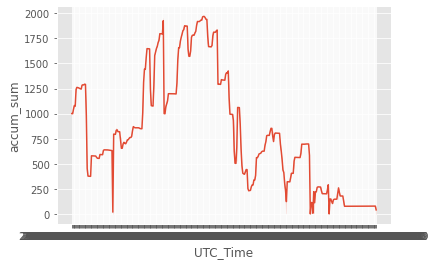

In [18]:
sns.lineplot(x='UTC_Time', y='accum_sum', data=df_futures);